# Lecture 16: Kernels and Feature Extraction

## CS4787 — Principles of Large-Scale Machine Learning Systems

$\newcommand{\N}{\mathbb{N}}$
$\newcommand{\Z}{\mathbb{Z}}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\C}{\mathbb{C}}$
$\newcommand{\norm}[1]{\left\| #1 \right\|}$
$\newcommand{\Exv}[2][]{\mathbf{E}_{#1}\left[ #2 \right]}$

Today we'll talk about a **powerful method** for scaling and improving the expressiveness of linear models: kernel methods.

### Kernel Methods: The Essential Idea

Imagine we are training a (simple 2-class) linear model with $w \in \mathbb{R}^d$ and total loss

$$f(w) = \frac{1}{n} \sum_{i=1}^n \ell(x_i^T w; y_i).$$

SGD for this task has an update step at time $t$ that samples $\tilde i_t$ uniformly at random and sets

$$w_{t+1} = w_t - \alpha_t \ell'(x_{\tilde i_t}^T w_t; y_{\tilde i_t}) x_{\tilde i_t}.$$

<span class="question">What is the computational cost of running $T$ of these updates?</span>

Sometimes, $d$ is very large, with $d \gg n$ $\rightarrow$ very expensive to compute!

**Goal: lower this cost.**

runtime: $O(Td)$

Let's look at the update of SGD again

$$w_{t+1} = w_t - \alpha_t \ell'(x_{\tilde i_t}^T w_t; y_{\tilde i_t}) x_{\tilde i_t}.$$

One thing that we notice is that (if we initialize $w_0 = 0$), $w_t$ is always in the span of the $x_i$. That is, it can always be written as a linear combination of the $x_i$. That is, for some constants $u_{i,t} \in \mathbb{R}$, we can always write

$$w_t = \sum_{i=1}^n u_{i,t} x_i.$$

With this setup, the SGD update looks like

\begin{align*}
u_{\tilde i_t, t+1} 
&= 
u_{\tilde i_t, t} - \alpha_t \ell'(x_{\tilde i_t}^T w_t; y_{\tilde i_t}) \\
&= 
u_{\tilde i_t, t} - \alpha_t \ell'\left(x_{\tilde i_t}^T \left( \sum_{i=1}^n u_{i,t} x_i \right); y_{\tilde i_t} \right) \\
&= 
u_{\tilde i_t, t} - \alpha_t \ell'\left( \sum_{i=1}^n u_{i,t} x_{\tilde i_t}^T x_i; y_{\tilde i_t} \right)
\end{align*}

with $u_{i,t+1} = u_{i,t}$ for $i \ne \tilde i_t$.

<span class="question">If we just run this naively, what is the computational cost of running $T$ of these updates?</span>

O(nTd)

So this update doesn't seem to be faster...but is there something clever we can do to speed it up?

Let's look at the update again.

$$u_{\tilde i_t, t+1} 
=
u_{\tilde i_t, t} - \alpha_t \ell'\left( \sum_{i=1}^n u_{i,t} {\color{red}{x_{\tilde i_t}^T x_i}}; y_{\tilde i_t} \right)$$

Most of the work is happening in this red dot product between two examples. **But these dot products are going to repeat many times!** In fact there are only $n^2$ of them. So, we can pre-compute them and cache them.

Let $G$ be the matrix defined by $G_{i,j} = x_i^T x_j$. This is usually called the **Gram matrix**. Then we can write our update as

$$u_{\tilde i_t, t+1} 
=
u_{\tilde i_t, t} - \alpha_t \ell'\left( \sum_{i=1}^n G_{\tilde i_t, i} u_{i,t}; y_{\tilde i_t} \right).$$

<span class="question">If we just run this naively, what is the computational cost of pre-computing the Gram matrix and running $T$ of these updates?</span>

It is indeed $O(d n^2 + Tn)$

$G_{i,j} = x_i^T x_j$

What's the computational cost of computing **1** entry of the gram matrix? A: $O(d)$

$G \in \R^{n \times n}$: for all of $G$, $O(n^2 d)$


**Takeaway: If $T \gg n^2$ and $d \gg n$, this approach can be faster.**

When can we make this **even faster**?

* A: When we have a way of computing $x_i^T x_j$ in time less than proportional to $d$.

This commonly happens when we have some examples $x_i$ that aren't necessarily stored as vectors in $\mathbb{R}^d$, but are stored in some format that we can map to vectors.

* i.e. we have not done feature extraction yet, but just have our original data examples (text, images, etc.) not mapped into a vector space yet

* Here, we want to run a linear model on vectors $\phi(x_i)$, where $\phi$ represents the _feature embedding_ from the "raw" example space into the feature vector space $\mathbb{R}^d$

* In some cases, we can compute $\phi(x_i)^T \phi(x_j)$ directly as some function $K(x_i, x_j)$. This function is called a kernel!

* If it is faster for us to compute the kernel $K$ than to compute the feature mappings $\phi$ and the dot products in $\R^d$, then we can get a speedup by computing the kernel function!

### Learning with kernels

In this pre-feature-embedding setting, we effectively want to solve the learning problem

$$f(w) = \frac{1}{n} \sum_{i=1}^n \ell(w^T \phi(x_i); y_i).$$

We can do this with the Gram matrix by pre-computing $G$ such that $G_{i,j} = K(x_i, x_j)$ and using SGD update

$$u_{\tilde i_t, t+1} = u_{\tilde i_t, t} - \alpha_t \ell'\left( \sum_{i=1}^n G_{\tilde i_t, i} u_{i,t}; y_{\tilde i_t} \right).$$

This approach is sometimes called the **kernel trick**.

### Designing learning tasks with kernels

Usually, rather than reasoning about (and designing and computing) feature embeddings $\phi$, we reason directly about kernel functions $K$.

**Which functions $K$ are kernels?** A kernel (also sometimes called a positive definite kernel) over a set $\mathcal{X}$ ($\mathcal{X}$ here represents the set that the "raw" examples live in) is a symmetric function $K(x, y): \mathcal{X} \times \mathcal{X} \rightarrow \R$.
By symmetric, we mean that $K(x, y) = K(y, x)$ for all $x$ and $y$ in $\mathcal{X}$.

To be a kernel, $K$ must satisfy the condition that for any $x_1, x_2, \ldots, x_n \in \mathcal{X}$, and for any scalars $c_1, c_2, \ldots, c_n \in \R$
$$\sum_{i=1}^n \sum_{j=1}^n c_i c_j K(x_i, x_j) \ge 0.$$
This is equivalent to saying that if we define the matrix $\mathbf{K} \in \R^{n \times n}$ by
$\mathbf{K}_{i,j} = K(x_i, x_j)$,
then $K$ will be positive semidefinite matrix. (Occasionally you will see authors distinguish between positve definite kernels and positive semidefinite kernels, which correspond to positive definite and positive semidefinite matrices respectively in this condition. But for this class and for most practical machine learning we won't depend on this distinction.)

* i.e. for any vector $c \in \R^n$, $c^T \mathbf{K} c \ge 0$.

* This is also equivalent to saying that any eigenvalue of $\mathbf{K}$ must be nonnegative.

### What do kernels represent?

Usually $K(x,y)$ represents how similar $x$ and $y$ are, where more similar objects will have larger values of $K(x,y)$ and less similar objects will have smaller values.
One very popular kernel is the **radial basis function** kernel or RBF kernel, sometimes also called the Gaussian kernel.
The RBF kernel is over a Euclidean space $\mathcal{X} = \R^d$ and takes the form

$$K(x, y) = \exp\left( -\gamma \norm{ x - y }^2 \right).$$

It's easy to see that $0 < K(x, y) \le 1$ and $K(x, y) = 1$ if and only if $x = y$.
These two properties informally mean that this kernel is expressing a similarity between $x$ and $y$ that ranges between $0$ and $1$, where $1$ is the most similar (i.e. literally identical objects $x = y$).

<span class="question">Question: What other kernels have you seen or used in your work? Do these kernels have the property that $0 < K(x, y) \le 1$ with $K(x,y) = 1$ if and only if $x = y$?</span>

**Grand list of Kernels**

* RBF

* Polynomial kernels: $(\gamma \cdot x^T y + r)^d$

* Sigmoid: $\tanh(\gamma \cdot x^T y + r)$

* Linear kernel: $x^T y$

* Kronecker delta: $$K(x,y) = \begin{cases} 1 & \text{if } x = y \\ 0 & \text{otherwise} \end{cases}$$

### A kernel determines a feature map.

Important property of kernels: for every kernel over a set $\mathcal{X}$, there exists a real Hilbert space (A Hilbert space is just a potentially infinite-dimensional generalization of Euclidean space that supports a dot product/inner product operation with the same properties as the Euclidean dot product.) $\mathcal{H}$ and a feature map $\phi: \mathcal{X} \rightarrow \mathcal{H}$ such that for any $x, y \in \mathcal{X}$,

$$K(x, y) = \phi(x)^T \phi(y) = \langle \phi(x), \phi(y) \rangle.$$

That is, every kernel is just a dot product in a (possibly infinite-dimensional) transformed space. 
This fact also holds in reverse: **every feature map determines a kernel**.

### Constructing kernels.

An important and very useful property of kernels is that we can construct kernels by combining other kernels.
Given any kernels $K_1$ and $K_2$ over a set $\mathcal{X}$ with corresponding features maps $\phi_1$ and $\phi_2$ mapping onto sets of dimension $D_1$ and $D_2$ respectively, any positive semi-definite matrix $A$, any scalar $c \ge 0$, and any function $f: \mathcal{X} \rightarrow \R$, the following are kernels.

| Our Newly Constructed Kernel Function | Corresponding Feature Map | Dimension of $\phi$ |
|--------|---------------------------|---------------------|
| $K(x, y) = x^T A y$ | $\phi(x) = \sqrt{A} \cdot x$ | $d$ (if $\mathcal{X} = \R^d$) |
| $K(x, y) = c \cdot K_1(x, y)$ | $\phi(x) = \sqrt{c} \cdot \phi_1(x)$ | $D_1$ |
| $K(x, y) = K_1(x,y) + K_2(x,y)$ | $\phi(x) = \begin{bmatrix}\phi_1(x) \\ \phi_2(x)\end{bmatrix}$ | $D_1 + D_2$ 
| $K(x, y) = K_1(x,y) \cdot K_2(x,y)$ | $\phi(x) = \phi_1(x) \otimes \phi_2(x)$ | $D_1 \cdot D_2$ |
| $K(x, y) = f(x) \cdot K_1(x,y) \cdot f(y)$ | $\phi(x) = \phi_1(x) \cdot f(x)$ | $D_1$ |
| $K(x, y) = \exp( K_1(x,y) )$ | (omitted for space) | $\infty$ ||

These rules let us easily construct a wide range of highly interpretive kernels.
But, as a trade-off, the dimension of the feature map $\phi$ <span class="problem">quickly becomes very large</span> as we apply the rules.
It can even become infinite!
This can make computing directly with the mapped features costly or even impossible.

* This makes using the kernel trick particularly important when we construct kernels in this way!

### Tradeoffs when Learning with Kernels

If we want to learn with a kernel where $K(x_i, x_j) = \langle \phi(x_i), \phi(x_j) \rangle$, then we have two broad options: to run the original SGD update step

$$w_{t+1} = w_t - \alpha_t \ell'(w^T \phi(x_{\tilde i_t}); y_{\tilde i_t}) \cdot \phi(x_{\tilde i_t}),$$

or the other option in terms of $u$

$$u_{\tilde i_t, t+1} - \alpha_t \ell'\left( \sum_{i=1}^n K(x_{\tilde i_t}, x_i) \cdot u_{i,t}; y_{\tilde i_t} \right).$$

For each option, we can choose whether or not to cache some of the computations. This gives us four simple options:

1. Transform the features on the fly and compute SGD on $w$, computing $\phi(x_i)$ whenever it is necessary.

2. Pre-compute and cache the transformed features, forming vectors $z_i = \phi(x_i)$, and compute SGD on $w$.

3. Run SGD on $u$ and compute the kernel values $K(x_j, x_i)$ on the fly as they are needed.

4. Pre-compute the kernel values for each pair of examples, forming the **Gram matrix** $G$ where $G_{i,j} = K(x_i, x_j)$, store it in memory, and then use this to run SGD on $u$
	
All of these methods will result in the same trained model at the end (assuming no numerical imprecision).

<span class="question">What is the computational cost and memory use of each of these methods?</question>

Suppose that the original examples are $x_i \in \R^d$, the transformed features are $\phi(x_i) \in \R^D$, there are $n$ total training examples, and we run $T$ iterations of SGD.
Also suppose that the cost of computing a single feature map $\phi(x_i)$ is $\Theta(d \cdot D)$ and the cost of computing the kernel function $K(x_i, y_i)$ is $\Theta(d)$.
What are the computational cost and memory required for these four methods, up to a big-$\Theta$ analysis?
Remember to include the cost of precomputation!

| Approach to learning with kernels | Computational cost | Memory use |
|-----------------------------------|--------------------|------------|
| 1. Transform the features on the fly and compute SGD on $w$ | $O(d D T)$ | $O(D)$ + training set |
| 2. Pre-compute and cache the transformed features, and compute SGD on $w$ | $O(n d D + TD)$ | $O(nD)$ + training set |
| 3. Run SGD on $u$ and compute the kernel values $K(x_j, x_i)$ on the fly | $O(ndT)$ | $O(n)$ + training set |
| 4. Pre-compute the Gram matrix, then run SGD on $u$ | $O(n^2 d + nT)$  | $O(n^2)$ + training set |

| Approach to learning with kernels | Computational cost | Memory use |
|-----------------------------------|--------------------|------------|
| 1. Transform the features on the fly and compute SGD on $w$ | O(dDT) |  O(D) + training set |
| 2. Pre-compute and cache the transformed features, and compute SGD on $w$ | O(ndD + DT) | O(nD) + training set |
| 3. Run SGD on $u$ and compute the kernel values $K(x_j, x_i)$ on the fly | O(ndT) |  O(n) + training set |
| 4. Pre-compute the Gram matrix, then run SGD on $u$ | O(n^2 d + nT) | O(n^2) + training set |

### A simple demo comparing two of these options

In [1]:
using PyPlot
using Statistics
using LinearAlgebra
using Random

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/cdesa/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [2]:
function gen_y(x::Array{Float64,1})
    if (norm(x - [0.25, 0.75]) < 0.15) 
        return -1.0
    elseif (norm(x - [0.75, 0.75]) < 0.15)
        return -1.0
    elseif (x[2] < 0.4) && (norm(x - [0.5,0.6]) < 0.5) && (norm(x - [0.5,0.55]) > 0.3)
        return -1.0;
    else
        return 1.0;
    end
end

Random.seed!(123456);
n = 1024;
xs = rand(2,n);
ys = [gen_y(xs[:,i]) for i = 1:n];

xs_test = rand(2,n);
ys_test = [gen_y(xs_test[:,i]) for i = 1:n];

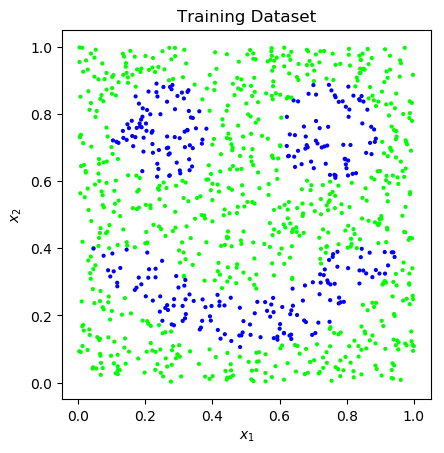

In [3]:
scatter(xs[1,:], xs[2,:], 4.0, c=ys, cmap="brg");
axis("square");
xlabel("\$x_1\$"); ylabel("\$x_2\$"); title("Training Dataset");

In [4]:
num_iters = 20 * n;
alpha = 0.1;
gamma = 100.0; # picked arbitrarily

# derivative of logistic loss
function ell_prime(wx::Float64, y::Float64)
    return -y ./ (1 .+ exp(wx*y));
end

function kernel_function(gamma::Float64, x::Array{Float64,1}, y::Array{Float64,1})
    acc = 0.0
    for i = 1:length(x)
        acc += (x[i] - y[i])^2
    end
    return exp(-gamma * acc);
end

function logistic_regression_gram_matrix(gamma::Float64, alpha::Float64, xs::Array{Float64,2}, ys::Array{Float64,1}, num_iters::Int64)
    n = size(xs, 2)
    gram_matrix = [kernel_function(gamma, xs[:,i], xs[:,j]) for i = 1:n, j = 1:n]
    
    u = zeros(n);
    
    for t = 1:num_iters
        i = rand(1:n);
        u[i] -= alpha * ell_prime(dot(gram_matrix[:,i], u), ys[i])
    end
    
    return u;
end

function logistic_regression_kernelfxn(gamma::Float64, alpha::Float64, xs::Array{Float64,2}, ys::Array{Float64,1}, num_iters::Int64)
    n = size(xs, 2)
    u = zeros(n);
    
    for t = 1:num_iters
        i = rand(1:n);
        u[i] -= alpha * ell_prime(sum(u[j] * exp(-gamma*sum((xs[k,i] - xs[k,j])^2 for k = 1:size(xs,1))) for j = 1:n), ys[i])
    end
    
    return u;
end


logistic_regression_kernelfxn (generic function with 1 method)

In [5]:
Random.seed!(856235)
@time u_gram = logistic_regression_gram_matrix(gamma, alpha, xs, ys, num_iters)

  0.210613 seconds (2.12 M allocations: 362.508 MiB, 15.58% gc time)


1024-element Array{Float64,1}:
  0.12738374762644594
 -0.07795723402253742
  0.20769035531666236
  0.13004044610756366
  0.33809523546666304
  0.212041349818893
  0.5609094175132032
 -0.7720800809116166
  0.2292933463053791
  0.10966234909821591
  0.6543568190277762
 -0.08172116899909224
  0.14774643122005687
  ⋮
  0.13420672195277883
 -0.2852043867702189
  1.088041374215776
  0.20946672319605658
 -0.7750031560839625
  0.27450255846412214
  0.21995910122094753
 -0.35968748170248416
  0.2803035176409706
 -0.04029995291766968
  0.14477561148672746
  0.2741866056098512

In [6]:
Random.seed!(856235)
@time u_kernel = logistic_regression_kernelfxn(gamma, alpha, xs, ys, num_iters)

  0.906893 seconds (42.19 M allocations: 969.978 MiB, 15.85% gc time)


1024-element Array{Float64,1}:
  0.1273837476264459
 -0.07795723402253733
  0.2076903553166623
  0.13004044610756382
  0.3380952354666631
  0.2120413498188931
  0.5609094175132033
 -0.7720800809116167
  0.22929334630537904
  0.10966234909821591
  0.6543568190277764
 -0.08172116899909222
  0.14774643122005687
  ⋮
  0.13420672195277877
 -0.28520438677021875
  1.088041374215776
  0.20946672319605664
 -0.7750031560839628
  0.2745025584641222
  0.21995910122094758
 -0.35968748170248416
  0.28030351764097056
 -0.04029995291766964
  0.14477561148672743
  0.27418660560985103

In [7]:
# did this get good test accuracy?

function kernel_classifier_prediction(u::Array{Float64,1}, xs_train::Array{Float64,2}, x_test::Array{Float64,1})
    return sign(sum(u[j] * kernel_function(gamma, x_test, xs_train[:,j]) for j = 1:n));
end
    
function kernel_classifier_accuracy(u::Array{Float64,1}, xs_train::Array{Float64,2}, xs_test::Array{Float64,2}, ys_test::Array{Float64,1})
    return mean(kernel_classifier_prediction(u, xs_train, xs_test[:,i]) == ys_test[i] for i = 1:length(ys_test))
end

kernel_classifier_accuracy (generic function with 1 method)

In [8]:
println("train accuracy: ", kernel_classifier_accuracy(u_gram, xs, xs, ys))
println(" test accuracy: ", kernel_classifier_accuracy(u_gram, xs, xs_test, ys_test))

train accuracy: 0.9892578125
 test accuracy: 0.970703125


**Takeaway: This analysis shows there is a trade-off between the four different methods for kernel learning.**
    
No one method is better than the others in all cases, and you should reason about how your learning task scales before deciding which method to use.

<span class="problem">One problematic case: what if we want to use a kernel with an infinite-dimensional feature map?</span>

* For example: the RBF kernel.

* Then $D = \infty$ in the analysis above, and methods (1) and (2) become impossible to run.

* On the other hand, methods (1) and (2) had the best dependence on $n$, and we would want to consider running one of these when the training set size becomes large.

<span class="question">How can we handle the case of large $n$ and large/infinite $D$?</span>

### Approximate feature maps.

Also called "feature extraction" sometimes.

Idea: approximate a possibly infinite-dimensional feature map $\phi$ of a kernel with a finite-dimensional feature map $\psi: \mathcal{X} \rightarrow \R^D$ such that for all $x, y \in \mathcal{X}$

$$K(x, y) = \phi(x)^T \phi(y) \approx \psi(x)^T \psi(y).$$

Then we can use the approximate feature map $\psi$ to learn with strategy (1) or (2) above.

<span class="question">Question: What are we trading off when we do this?</span>

### How do we construct these approximate feature maps?

There are many ways to do it.
Here, I'm going to be talking about one way we can do this for the RBF kernel, a method called **Random Fourier features** (Ali Rahimi and Ben Recht, "Random Features for Large-Scale Kernel Machines." _Advances in neural information processing systems, 2008_. This paper won the test of time award at NeurIPS 2017.)

The strategy is straightforward (although the math can get a little tricky).

* First, we write the kernel $K(x,y)$ in terms of an expected value.
* Second, we use our **subsampling principle** to approximate this expected value with a finite sample to within the desired level of accuracy . 
* Third, we use this finite sample to construct an approximate feature map.

If we sample $\omega$ from a $d$-dimensional multivariate Gaussian distribution with mean $0$ and covariance $2 \gamma I$, and independently sample $b$ to be uniform on $[0, 2\pi]$, then we can show that for any $x, y \in \R^d$,

$$K(x, y)
	=
	\exp\left(-\gamma \norm{x - y}^2 \right)
	=
	\Exv[\omega, b]{2 \cdot \cos(\omega^T x + b) \cdot \cos(\omega^T y + b)}.$$
    
They did it with a proof...I'll show it in the Jupyter notebook!

In [9]:
gamma = 0.1;

d = 10;
x = rand(d); y = rand(d); # get some random vectors

function supposed_estimator(gamma::Float64, x::Array{Float64,1}, y::Array{Float64,1})
    d = length(x);
    w = randn(d) * sqrt(2*gamma)
    b = 2 * pi * rand();
    return 2 * cos(dot(w,x) + b) * cos(dot(w,y) + b);
end;

In [19]:
num_samples = 100000;

println("kernel function value: ", kernel_function(gamma, x, y));
println("      estimated value: ", mean(supposed_estimator(gamma, x, y) for i = 1:num_samples));

kernel function value: 0.9291306670680894
      estimated value: 0.9312256793916118


They're pretty close! So we can believe that this is indeed an unbiased estimator of the kernel function.

Now we can apply our subsampling principle to approximate this expected value with a finite sum.
Pick some number $D$ and let $\omega_1, b_1, \omega_2, b_2, \ldots, \omega_D, b_D$ be independent random samples of $\omega \sim \mathcal{N}(0,2 \gamma I)$ and $b \sim \operatorname{Uniform}[0,2\pi]$.
Then

\begin{align*}
	K(x, y)
	&\approx
	\frac{1}{D} \sum_{i=1}^D 2 \cdot \cos(\omega_i^T x + b_i) \cdot \cos(\omega_i^T y + b_i) \\
	&=
	\sum_{i=1}^D \left( \sqrt{\frac{2}{D}} \cdot \cos(\omega_i^T x + b_i) \right) \cdot \left( \sqrt{\frac{2}{D}} \cdot \cos(\omega_i^T y + b_i) \right).
\end{align*}

So if we define the feature map $\psi(x)$ such that its $i$th element is

$$(\psi(x))_i = \sqrt{\frac{2}{D}} \cdot \cos(\omega_i^T x + b_i),$$

then

$$K(x,y) \approx \sum_{i=1}^D (\psi(x))_i (\psi(y))_i = \psi(x)^T \psi(y)$$

and we have our approximate feature map!
Note that we can also write $\psi$ in terms of matrix multiply as

$$\psi(x) = \sqrt{\frac{2}{D}} \cdot \cos(\Omega x + \mathbf{b}),$$

where $\Omega$ and $\mathbf{b}$ denote the matrix and vector

$$\Omega = \begin{bmatrix} \omega_1^T \\ \vdots \\ \omega_D^T \end{bmatrix}
\hspace{2em}\text{ and }\hspace{2em}
\mathbf{b} = \begin{bmatrix} b_1 \\ \vdots \\ b_D \end{bmatrix}$$

and the $\cos$ operates elementwise.

**What thing that we've already seen does this look like?**

* It looks like a neural network with random weights and a cosine nonlinearity!

How close will this be to the exact RBF kernel? One way to get a sense of it is to use Hoeffding's inequality.
Since the elements of this sum are all of the form $2 \cos(\cdot) \cos(\cdot)$, they must have magnitude no greater than $2$.
As a result, $z_{\min} = -2$, $z_{\max} = 2$, and we get

$$\mathbf{P}\left(
		\left| K(x, y) - \psi(x)^T \psi(y) \right|
		\ge
		a
	\right)
	\le
	2 \exp\left( - \frac{ 2 D a^2 }{(2 - (-2))^2} \right)
	=
	2 \exp\left( - \frac{ D a^2 }{8} \right).$$

**Takeaway: We can get arbitrarily good accuracy with arbitrarily high probability by increasing $D$.** In their paper, Rahimi and Recht show how they can make a similar statement that holds **for all pairs $x, y$ in a bounded region**, as opposed to just for a specific pair.

This is just one example of a broad class of techniques that can be used for feature extraction for kernels.
This adds the following extra techniques to our list of ways to do kernel learning:

5. Pre-compute an approximate feature map (e.g. sample $\Omega$ and $\mathbf{b}$ for random Fourier features on RBF) and use it to compute approximate features on the fly to compute SGD in $w$-space.
6. Pre-compute an approximate feature map, then also pre-compute and cache the transformed approximate features, forming vectors $z_i = \psi(x_i)$. Then run SGD in $w$-space.

Often, using an approximate feature map like this is the most efficient way of training a model.

 * But...not always!

When learning with a kernel, we need to **keep the properties of the problem in mind** to decide how to proceed with learning most efficiently.